1804


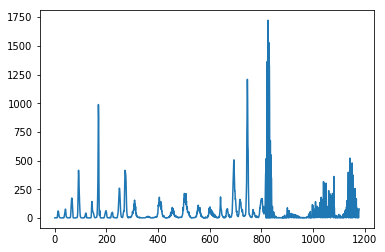

In [1]:
PROVINCE = "50"
import matplotlib.pyplot as plt
count = 0
total_cases = []
with open("total_data.csv") as f:
    for line in f.readlines():
        #print (line)
        if count ==0:
            count +=1
        else:
            line_split = line.split(",")
            
            if line_split[2] == PROVINCE and len(line_split) >=3:
                total_cases.append(float(line_split[3]))
                
print (len(total_cases))
proc_training_data_base = total_cases[(26*20):(len(total_cases) - 26*4)]
plt.plot(proc_training_data_base)
plt.show()

/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in divide


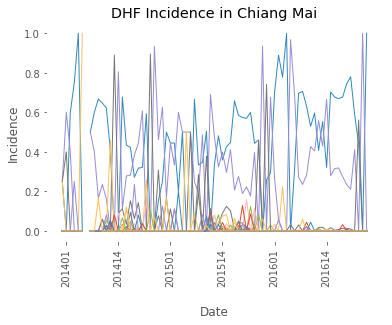

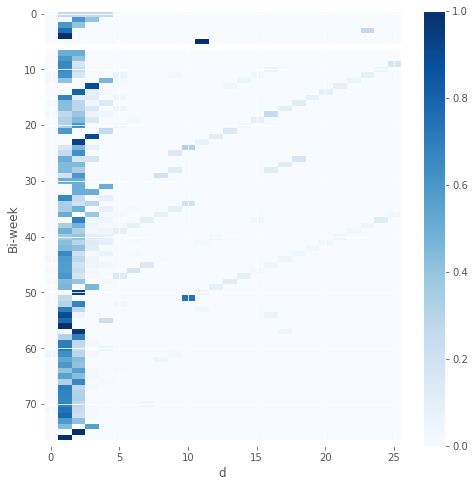

In [2]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
            
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['lines.linewidth']=1
plt.rcParams['axes.facecolor']='w'

n_t_d = []
with open("province-biweek_with_delays.csv") as f:
    i = 0
    for line in f.readlines():
        if i > 0:
            n_t_d.append(line.replace("\n","").split(','))
        i+=1

n_t_d_1 = []

for elm in n_t_d:
    if elm[2] == PROVINCE:
        n_t_d_1.append(elm)


index_to_dates = {}
dates_to_index = {}
count = 0
for i in ["2014","2015","2016"]:
    for j in range(1,27):
        index_to_dates[count] = str(i)+str(j)
        dates_to_index[str(i)+str(j)] = count
        count +=1
        
reporting_matrix = np.zeros((26*3,26*3))

for elm in n_t_d_1:
    try:
        sick_date = elm[0]+elm[1]
        report_date = elm[-2] + elm[-1]
        cases = elm[3]
        reporting_matrix_row = dates_to_index[sick_date] 
        reporting_matrix_col =  dates_to_index[report_date] 
        reporting_matrix[reporting_matrix_row,reporting_matrix_col] = int(cases)
    except:
        pass
np.set_printoptions(suppress=True)    #np.set_printoptions(threshold=np.nan)


D=26
n_t_d = np.zeros((len(reporting_matrix),D))

for i in range(len(reporting_matrix)):
    for j in range(i,i+D):
        try:
            n_t_d[i,j-i] = reporting_matrix[i][j]
        except:
            pass
n_t_d = n_t_d 

from matplotlib.pyplot import cm


def sim_data(x,y,z):
    return n_t_d[:y]



pos=[]
biweek_x_label = []
for year in ["2014","2015","2016"]:
    for j in np.arange(1,27,13):
        if j <= 9:
               biweek_x_label.append(year + "0"+ str(j))

        else:
               biweek_x_label.append(year +  str(j))
        if year == "2014":
               pos.append(j)
        elif year == "2015":
               pos.append(j+26)
        elif year == "2016":
               pos.append(j+26*2)

p_hat_sim = []

for i in range(len(n_t_d)):
        #print (sum(sim_n_t_d[i]/np.sum(sim_n_t_d[i])))
        p_hat_sim.append(n_t_d[i]/np.sum(n_t_d[i]))


plt.plot(p_hat_sim)
plt.xticks(pos, biweek_x_label, rotation='vertical')
plt.xlabel("\nDate")
plt.title("DHF Incidence in Chiang Mai")
plt.ylabel("Incidence")
plt.show()

plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat_sim,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()



In [47]:
from scipy.stats import norm

from scipy.stats import binom
from scipy.stats import poisson

def bayes_estimate_prob(po_data,m2,alphas,LO,N_SIM):
    ret_arr = []
    #print (po_data)
    #sys.exit()
    phat = alphas/sum(alphas)
  
    for row in np.arange(LO,0,-1):

        count = LO
        tmp = []
        
        for s_ in range(N_SIM):
                prior_prob_curr = 0
                likelihood_prob_curr = 0
                init_cand = po_data[D-row]
                p_hat = np.random.dirichlet(alphas,1)[0]
                
                #current_partially_observed = po_data[D-row]   #currently
                trace = []
                for MCMC in range(1000):

                    tmp_n_t_inf_proposal = np.random.poisson(init_cand)
                    #print (tmp_n_t_inf_proposal,po_data[D-row],sum(phat[:row]),phat,row)
                    prior_prob_prop = norm.pdf(tmp_n_t_inf_proposal,m2[s_][D-row],100)
                    likelihood_prob_prop = binom.pmf(po_data[D-row],tmp_n_t_inf_proposal,sum(phat[:row]))
                    accp_prob_num = poisson.pmf(init_cand,tmp_n_t_inf_proposal)*prior_prob_prop*likelihood_prob_prop

                    prior_prob_prop = norm.pdf(init_cand,m2[s_][D-row],100)
                    likelihood_prob_prop = binom.pmf(po_data[D-row],init_cand,sum(phat[:row]))

                    accp_prob_denom = poisson.pmf(tmp_n_t_inf_proposal,init_cand)*prior_prob_prop*likelihood_prob_prop

                    unif_ = np.random.uniform(0,1)
                    if unif_ < 1.*accp_prob_num/accp_prob_denom:
                        init_cand = tmp_n_t_inf_proposal
                    
                    if np.isnan(init_cand):
                        print ("Hello")
                    trace.append(init_cand)
              
                tmp.append(trace)
                #ret_arr.append(po_data[D-row]/sum(phat[:row]))
        count -=1
        ret_arr.append(tmp)
        
    return ret_arr

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


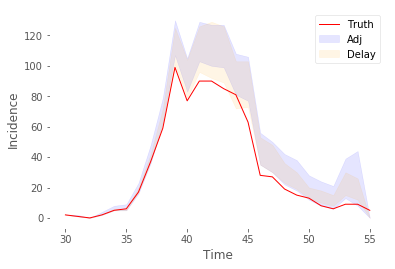

[8.904692307692308, 47.32100000000001, 10.535696153846153]
(0.38461538461538464, 0.07692307692307693, 0.5)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


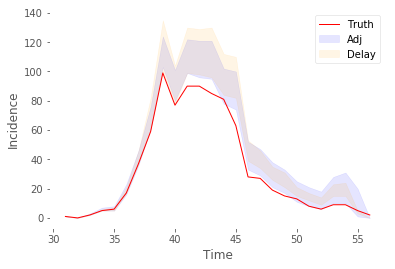

[9.56269230769231, 46.92415384615385, 8.165465384615384]
(0.3076923076923077, 0.11538461538461539, 0.46153846153846156)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


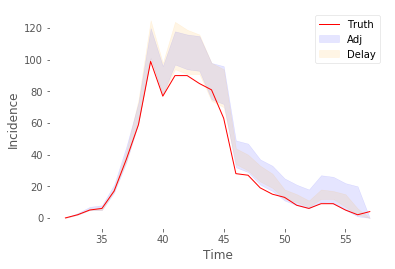

[5.979923076923076, 47.115269230769236, 7.235223076923077]
(0.34615384615384615, 0.11538461538461539, 0.5)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


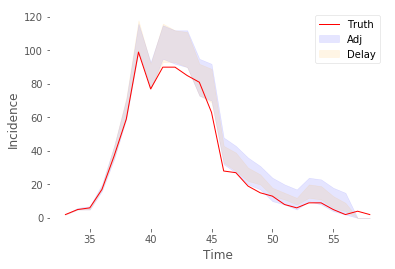

[6.105769230769231, 47.46761538461538, 6.04783076923077]
(0.3076923076923077, 0.038461538461538464, 0.6153846153846154)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


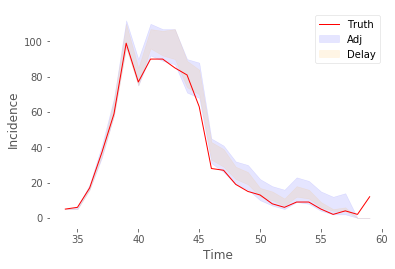

[4.5765769230769235, 47.755538461538464, 4.921957692307692]
(0.34615384615384615, 0.038461538461538464, 0.7307692307692307)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


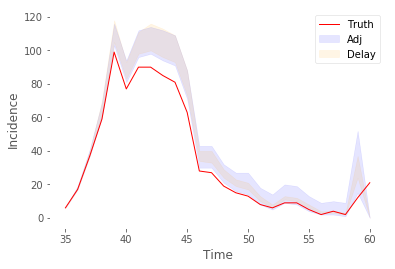

[7.498038461538463, 48.55588461538461, 7.834796153846154]
(0.23076923076923078, 0.038461538461538464, 0.4230769230769231)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


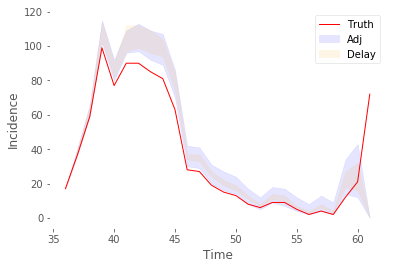

[8.933384615384615, 46.61507692307692, 8.895992307692309]
(0.11538461538461539, 0.038461538461538464, 0.46153846153846156)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


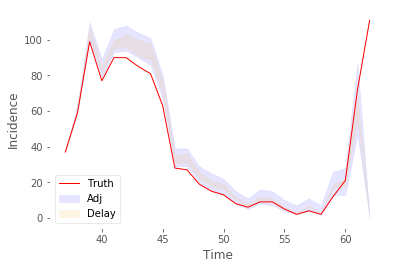

[8.476461538461537, 48.401538461538465, 8.840403846153846]
(0.19230769230769232, 0.07692307692307693, 0.5384615384615384)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


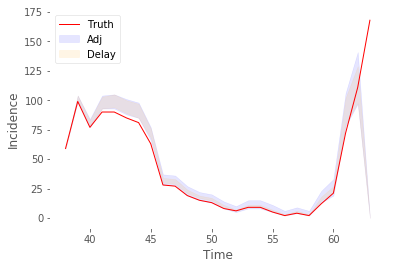

[10.840307692307691, 51.66473076923077, 10.755738461538462]
(0.2692307692307692, 0.07692307692307693, 0.6538461538461539)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


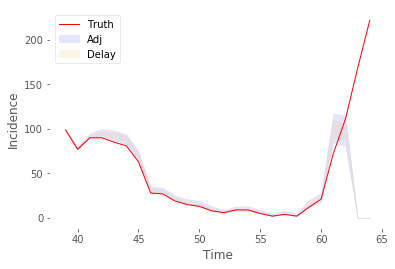

[18.524653846153846, 55.863653846153845, 18.614003846153846]
(0.3076923076923077, 0.038461538461538464, 0.7307692307692307)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


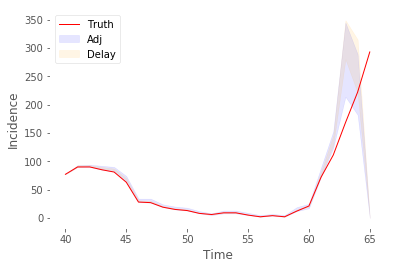

[20.84711538461538, 61.40950000000001, 19.608711538461538]
(0.34615384615384615, 0.038461538461538464, 0.7692307692307693)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


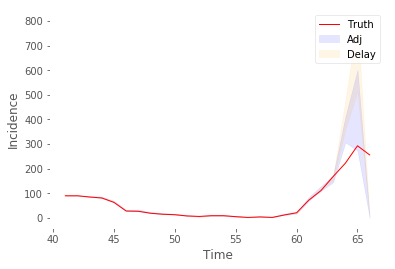

[32.64396153846153, 68.71153846153845, 25.892473076923082]
(0.38461538461538464, 0.0, 0.9230769230769231)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


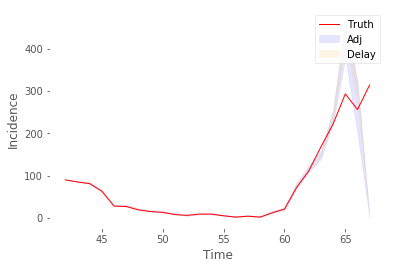

[21.396346153846153, 78.69242307692308, 20.25095384615384]
(0.34615384615384615, 0.0, 0.8461538461538461)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


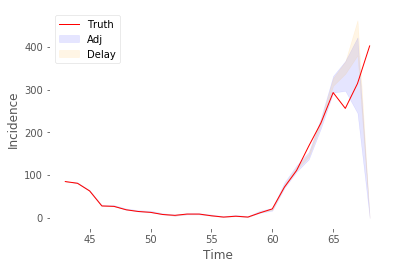

[25.704000000000004, 89.33934615384617, 22.860100000000003]
(0.5, 0.0, 0.8846153846153846)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


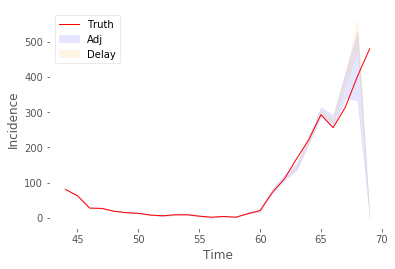

[27.496692307692307, 104.128, 25.78353846153846]
(0.5384615384615384, 0.0, 0.8461538461538461)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


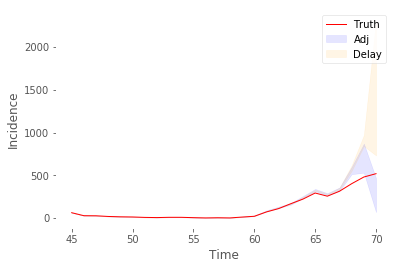

[67.26384615384616, 121.13965384615383, 30.87028461538462]
(0.46153846153846156, 0.0, 0.6538461538461539)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


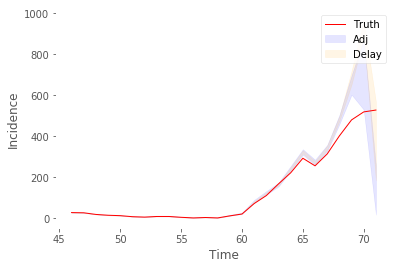

[40.81623076923078, 139.24153846153848, 40.87983846153846]
(0.5769230769230769, 0.0, 0.6153846153846154)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


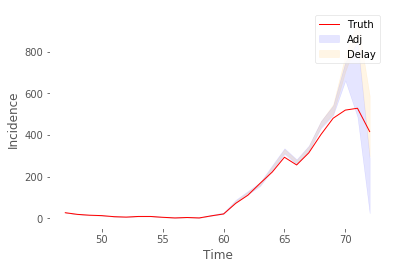

[31.695153846153843, 154.92038461538462, 34.137307692307694]
(0.5384615384615384, 0.0, 0.6153846153846154)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


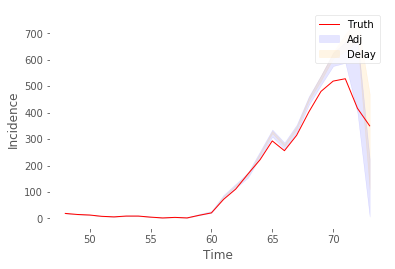

[33.99642307692308, 168.22661538461537, 32.229896153846155]
(0.46153846153846156, 0.0, 0.5769230769230769)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


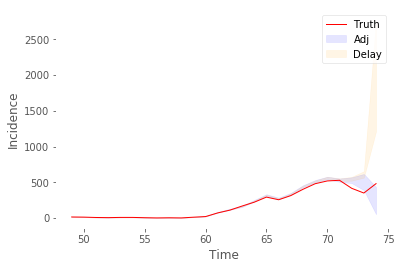

[76.84130769230771, 187.137, 29.390334615384614]
(0.4230769230769231, 0.0, 0.5384615384615384)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


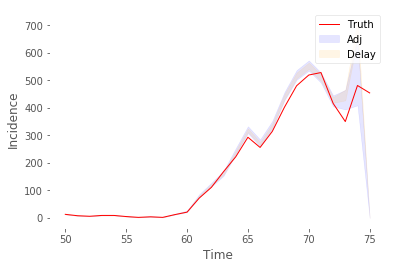

[38.66511538461539, 204.43111538461537, 34.5027923076923]
(0.34615384615384615, 0.0, 0.5769230769230769)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


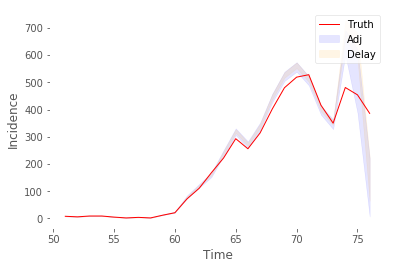

[34.930653846153845, 215.79884615384614, 31.647796153846155]
(0.34615384615384615, 0.0, 0.5)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


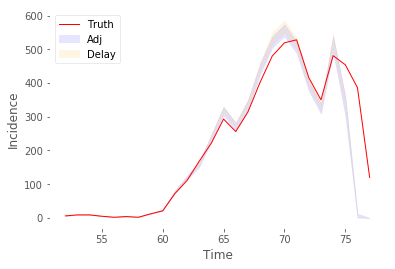

[36.952769230769235, 219.66823076923077, 36.35183461538462]
(0.34615384615384615, 0.0, 0.34615384615384615)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


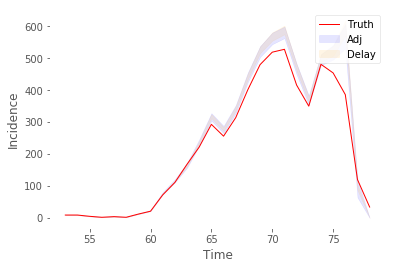

[27.23169230769232, 220.33803846153845, 25.524623076923074]
(0.2692307692307692, 0.038461538461538464, 0.46153846153846156)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


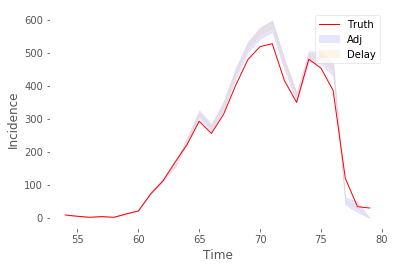

[22.324769230769228, 220.02284615384616, 20.30821923076923]
(0.23076923076923078, 0.0, 0.4230769230769231)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


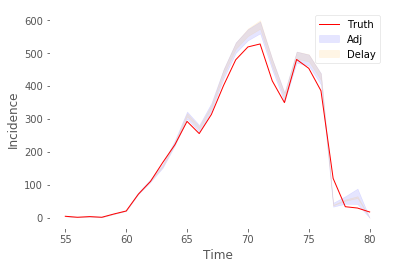

[22.81088461538462, 218.99749999999997, 19.934973076923082]
(0.23076923076923078, 0.038461538461538464, 0.38461538461538464)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


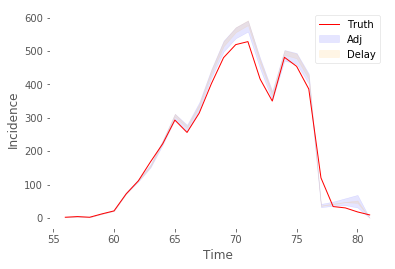

[21.154730769230767, 219.25223076923078, 18.31426153846154]
(0.23076923076923078, 0.0, 0.34615384615384615)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


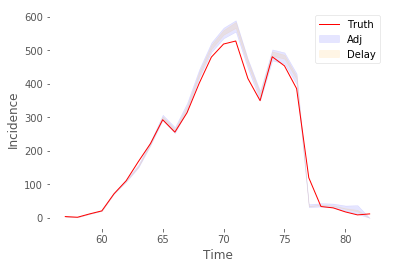

[17.629884615384615, 219.06623076923077, 16.261203846153848]
(0.23076923076923078, 0.0, 0.46153846153846156)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


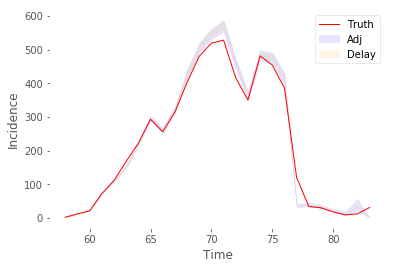

[16.578153846153846, 220.48746153846153, 15.860607692307688]
(0.2692307692307692, 0.0, 0.5384615384615384)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


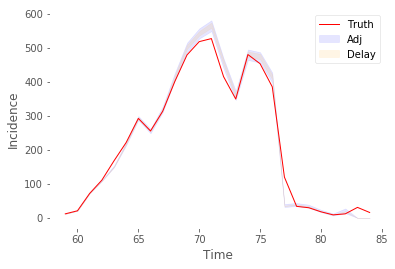

[15.163769230769228, 220.825, 14.294153846153844]
(0.2692307692307692, 0.038461538461538464, 0.5)


In [48]:
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error
from pyramid.arima import ARIMA

import os

rmse_vec_cv = []
#with suppress_stdout():
rmse_vec = []
sim_data_var = []
N_SIM = 10
sim_results_pi = []
sim_results_mse = []
for sim_num in np.arange(30,60):
            sim_n_t_d = sim_data(D,sim_num,False)
            train = sim_n_t_d
            


            train = np.array(train)
            train_n_t_d = train.reshape((-1,D))
            ts = train_n_t_d.sum(axis=1)
            data_to_be_scaled_down  = train_n_t_d[len(ts)-D:]




            delayed_data = []
            count = D
            for i in range(len(data_to_be_scaled_down)):
                tmp = data_to_be_scaled_down[i][:count].tolist()
                while len(tmp) <D:
                    tmp.append(0)
                delayed_data.append(tmp)
                count -=1 


            training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

            k = np.array(train_n_t_d).shape[1 ]
            alphas = np.ones(k)

            for i in range(len(ts)-D):
                alphas += train_n_t_d[i]

            
           
            #######
            # MODEL 1: Delay
            ########
            delay_model_samples = []
            for s_ in range(N_SIM):
                model_1_delay = []
                count = D
                p_vec_noise = np.random.dirichlet(alphas)
                for i in range(len(delayed_data)):
                    delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
                    model_1_delay.append(np.round(delay_forecast,2))
                    count -= 1
                delay_model_samples.append(model_1_delay)
            
            delay_model_samples = np.array(delay_model_samples)
            

            #######
            # MODEL 2 : Forecast
            ########
            
            LO=D
            process_training_data = np.append(ts[:len(ts)-D],model_1_delay[:D-LO],axis=0)
            process_training_data = np.append(proc_training_data_base,process_training_data,axis=0)
            from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
            myDLM = dlm(process_training_data)
            myDLM = myDLM + seasonality(26, name='7day', w=.5)
            myDLM = myDLM + autoReg(degree=3, data=process_training_data, name='ar2', w=1.0)
            myDLM.fit()
            (process_model_forecast, predictVar) = myDLM.predictN(N=LO, date=myDLM.n-1)
            
            
            
            #stepwise_model = auto_arima(process_training_data, start_p=1, start_q=1,
            #               max_p=3, max_q=3, m=26,
            #               start_P=0, seasonal=True,
            #               d=1, D=1, trace=True,
            ##               error_action='ignore',  
             #              suppress_warnings=True, 
             #              stepwise=True)
            #process_model_forecast = stepwise_model.predict(n_periods=LO)
           
            predictVar = 1*np.ones(len(process_model_forecast))
            #######
            # MODEL 2
            ########
            forecast_model_samples = []
            for s_ in range(N_SIM):
                model_2_delay = []
                count = D
                for i in np.arange(LO,0,-1):
                    tmp = np.random.normal(process_model_forecast[LO-i],np.sqrt(predictVar[LO-i]))
                    model_2_delay.append(np.round(tmp,2))
                    count -= 1

                forecast_model_samples.append(np.append(model_1_delay[:D-LO],model_2_delay))
            
            forecast_model_samples = np.array(forecast_model_samples)
            
                
            model_average = bayes_estimate_prob(np.sum(delayed_data,axis=1),forecast_model_samples,alphas,LO,N_SIM)
            
            delay_model_samples = np.transpose(np.array(delay_model_samples))
            forecast_model_samples = np.transpose(np.array(forecast_model_samples))
            
            delay_sim_res = delay_model_samples
            fcast_sim_res = forecast_model_samples
            avg_sim_res = model_average
            LO_av = np.array(avg_sim_res).reshape((LO,-1))
            LO_delay = delay_sim_res[D-LO:]
            LO_fcast = fcast_sim_res[D-LO:]
            LO_truth = ts[len(ts)-LO:]
            #print (np.mean(LO_delay,axis=1),np.mean(LO_fcast,axis=1),LO_truth\
                   #,np.mean(LO_av,axis=1))
            #sys.exit()
            sim_results_mse.append([mean_absolute_error(np.mean(LO_delay,axis=1),LO_truth),\
                                   mean_absolute_error(np.mean(LO_fcast,axis=1),LO_truth),\
                                   mean_absolute_error(np.mean(LO_av,axis=1),LO_truth)])
            #print (sim_results_mse[-1])
            av_cp = 0
            fcast_cp = 0
            delay_cp = 0
            LO_av_low = []
            LO_av_high = []
            LO_delay_low = []
            LO_delay_high = []
            for i in range(LO):
                LO_av_ci = np.round(np.percentile(LO_av[i],[2.5,97.5]))
                LO_fcast_ci = np.round(np.percentile(LO_fcast[i],[2.5,97.5]))
                LO_delay_ci = np.round(np.percentile(LO_delay[i],[2.5,97.5]))
                LO_av_low.append(LO_av_ci[0])
                LO_av_high.append(LO_av_ci[1])
                LO_delay_low.append(LO_delay_ci[0])
                LO_delay_high.append(LO_delay_ci[1])
                
                #plt.fill_between([i],[LO_delay_ci[0]],[LO_delay_ci[1]])
               # plt.fill_between([i],LO_fcast_ci[0],LO_fcast_ci[1])
                #plt.fill_between([i],[LO_av_ci[0]],[LO_av_ci[1]])
                
                if LO_av_ci[0] <= LO_truth[i] <= LO_av_ci[1]:
                    av_cp +=1

                if LO_fcast_ci[0] <= LO_truth[i] <= LO_fcast_ci[1]:
                    fcast_cp +=1

                if LO_delay_ci[0] <= LO_truth[i] <= LO_delay_ci[1]:
                    delay_cp +=1

            plt.fill_between(range(sim_num,LO+sim_num),LO_av_low,LO_av_high,alpha=.1,color='blue')
            plt.fill_between(range(sim_num,LO+sim_num),LO_delay_low,LO_delay_high,alpha=.1,color='orange')
            plt.plot(range(sim_num,sim_num+LO),LO_truth,color='red')
            plt.legend(("Truth","Adj","Delay"))
            plt.ylabel("Incidence")
            plt.xlabel("Time")
            plt.show()
            #sys.exit()
            av_cp = 1.*av_cp/LO
            fcast_cp = 1.*fcast_cp/LO
            delay_cp = 1.*delay_cp/LO
            print (sim_results_mse[-1])
            print (delay_cp,fcast_cp,av_cp)
            sim_results_pi.append([delay_cp,fcast_cp,av_cp])

In [49]:
from tabulate import tabulate

print np.mean(sim_results_pi,axis=0)
sim_results_mse = np.array(sim_results_mse)

sim_results_mse_formatted = []
for i in range(len(sim_results_mse)):
    sim_results_mse_formatted.append([i+30,sim_results_mse[i][0],sim_results_mse[i][2]])
    
print(tabulate(sim_results_mse_formatted, tablefmt="latex", floatfmt=".2f"))

print np.round(np.mean(sim_results_mse,axis=0))

wins = 0
for i in range(len(sim_results_mse)):
    if sim_results_mse[i][2] < sim_results_mse[i][0]:
        wins +=1
        
print (1.*wins/(len(sim_results_mse)))


[0.33846154 0.02692308 0.58076923]
\begin{tabular}{rrr}
\hline
 30 &  8.90 & 10.54 \\
 31 &  9.56 &  8.17 \\
 32 &  5.98 &  7.24 \\
 33 &  6.11 &  6.05 \\
 34 &  4.58 &  4.92 \\
 35 &  7.50 &  7.83 \\
 36 &  8.93 &  8.90 \\
 37 &  8.48 &  8.84 \\
 38 & 10.84 & 10.76 \\
 39 & 18.52 & 18.61 \\
 40 & 20.85 & 19.61 \\
 41 & 32.64 & 25.89 \\
 42 & 21.40 & 20.25 \\
 43 & 25.70 & 22.86 \\
 44 & 27.50 & 25.78 \\
 45 & 67.26 & 30.87 \\
 46 & 40.82 & 40.88 \\
 47 & 31.70 & 34.14 \\
 48 & 34.00 & 32.23 \\
 49 & 76.84 & 29.39 \\
 50 & 38.67 & 34.50 \\
 51 & 34.93 & 31.65 \\
 52 & 36.95 & 36.35 \\
 53 & 27.23 & 25.52 \\
 54 & 22.32 & 20.31 \\
 55 & 22.81 & 19.93 \\
 56 & 21.15 & 18.31 \\
 57 & 17.63 & 16.26 \\
 58 & 16.58 & 15.86 \\
 59 & 15.16 & 14.29 \\
\hline
\end{tabular}
[ 24. 128.  20.]
0.733333333333


In [37]:
from scipy.special import expit
import matplotlib.pyplot as pltq

variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error

cv_mse = []
season_data = []
sim_results_mse = []
sim_results_pi = []
for i in range(3):
    season_data.append(n_t_d[i:(i+26)])
    
season_data = np.array(season_data).reshape((3,-1,26))

print (season_data.shape)

for season_for_leave_out in np.arange(3):
        sim_n_t_d = season_data#[:cutoff]

        train = [sim_n_t_d[x] for x in range(3) if x not in [season_for_leave_out]]
        test = sim_n_t_d[season_for_leave_out]
        
        train = np.array(train)
        train_n_t_d = train.reshape((-1,D))
        ts = train_n_t_d.sum(axis=1)

        data_to_be_scaled_down  = test[len(test)-D:]
       
        delayed_data = []
        count = D
        for i in range(len(data_to_be_scaled_down)):
            tmp = data_to_be_scaled_down[i][:count].tolist()
            while len(tmp) <D:
                tmp.append(0)
            delayed_data.append(tmp)
            count -=1 


        training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

        k = np.array(train_n_t_d).shape[1 ]
        alphas = np.ones(k)

        for i in range(len(ts)-D):
            alphas += train_n_t_d[i]



        #######
        # MODEL 1: Delay
        ########
        delay_model_samples = []
        for s_ in range(N_SIM):
            model_1_delay = []
            count = D
            p_vec_noise = np.random.dirichlet(alphas)
            for i in range(len(delayed_data)):
                delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
                model_1_delay.append(np.round(delay_forecast,2))
                count -= 1
            delay_model_samples.append(model_1_delay)

        delay_model_samples = np.array(delay_model_samples)


        #######
        # MODEL 2 : Forecast
        ########

        LO=D
        process_training_data = np.append(ts[:len(ts)-D],model_1_delay[:D-LO],axis=0)
        from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
        myDLM = dlm(process_training_data)
       # myDLM = myDLM + seasonality(26, name='7day', w=1.0)
        myDLM = myDLM + autoReg(degree=2, data=process_training_data, name='ar2', w=1.0)
        myDLM.fit()
        (process_model_forecast, predictVar) = myDLM.predictN(N=LO, date=myDLM.n-1)

        #######
        # MODEL 2
        ########
        forecast_model_samples = []
        for s_ in range(N_SIM):
            model_2_delay = []
            count = D
            for i in np.arange(LO,0,-1):
                tmp = np.random.normal(process_model_forecast[LO-i],np.sqrt(predictVar[LO-i]))
                model_2_delay.append(np.round(tmp,2))
                count -= 1

            forecast_model_samples.append(np.append(model_1_delay[:D-LO],model_2_delay))

        forecast_model_samples = np.array(forecast_model_samples)


        model_average = bayes_estimate_prob(np.sum(delayed_data,axis=1),forecast_model_samples,alphas,LO,N_SIM)
            
        delay_model_samples = np.transpose(np.array(delay_model_samples))
        forecast_model_samples = np.transpose(np.array(forecast_model_samples))
            
        delay_sim_res = delay_model_samples
        fcast_sim_res = forecast_model_samples
        avg_sim_res = model_average
        LO_av = np.array(avg_sim_res).reshape((LO,-1))
        LO_delay = delay_sim_res[D-LO:]
        LO_fcast = fcast_sim_res[D-LO:]
        LO_truth = ts[len(ts)-LO:]
        #print (np.mean(LO_delay,axis=1),np.mean(LO_fcast,axis=1),LO_truth\
               #,np.mean(LO_av,axis=1))
        #sys.exit()
        sim_results_mse.append([mean_absolute_error(np.mean(LO_delay,axis=1),LO_truth),\
                               mean_absolute_error(np.mean(LO_fcast,axis=1),LO_truth),\
                               mean_absolute_error(np.mean(LO_av,axis=1),LO_truth)])
        print (sim_results_mse[-1])
        av_cp = 0
        fcast_cp = 0
        delay_cp = 0
        for i in range(LO):
            LO_av_ci = np.round(np.percentile(LO_av[i],[2.5,97.5]))
            LO_fcast_ci = np.round(np.percentile(LO_fcast[i],[2.5,97.5]))
            LO_delay_ci = np.round(np.percentile(LO_delay[i],[2.5,97.5]))
            print (LO_delay_ci,LO_fcast_ci,LO_av_ci, LO_truth[i])
            if LO_av_ci[0] <= LO_truth[i] <= LO_av_ci[1]:
                av_cp +=1

            if LO_fcast_ci[0] <= LO_truth[i] <= LO_fcast_ci[1]:
                fcast_cp +=1

            if LO_delay_ci[0] <= LO_truth[i] <= LO_delay_ci[1]:
                delay_cp +=1


        av_cp = 1.*av_cp/LO
        fcast_cp = 1.*fcast_cp/LO
        delay_cp = 1.*delay_cp/LO

        print (delay_cp,fcast_cp,av_cp)
        sim_results_pi.append([delay_cp,fcast_cp,av_cp])

(3, 26, 26)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[15.051926923076925, 32.414211538461544, 14.958975435630133]
(array([4., 4.]), array([-20.,  34.]), array([4., 4.]), 5.0)
(array([5., 5.]), array([-18.,  29.]), array([5., 5.]), 4.0)
(array([5., 5.]), array([-16.,  27.]), array([5., 5.]), 2.0)
(array([3., 3.]), array([-23.,  20.]), array([3., 3.]), 1.0)
(array([2., 2.]), array([-23.,  21.]), array([2., 2.]), 0.0)
(array([1., 1.]), array([-27.,  26.]), array([1., 1.]), 2.0)
(array([0., 0.]), array([-25.,  25.]), array([0., 0.]), 5.0)
(array([2., 2.]), array([-26.,  25.]), array([2., 2.]), 6.0)
(array([5., 5.]), array([-25.,  22.]), array([5., 6.]), 17.0)
(array([5., 5.]), array([-26.,  24.]), array([5., 6.]), 37.0)
(array([16., 17.]), array([-21.,  26.]), array([14., 19.]), 59.0)
(array([36., 37.]), array([-24.,  26.]), array([30., 43.]), 99.0)
(array([58., 60.]), array([-27.,  20.]), array([48., 71.]), 77.0

In [39]:

#### sim_results_pi = np.array(sim_results_pi)#### sim 
print np.mean(sim_results_pi,axis=0)

sim_results_mse = np.array(sim_results_mse)
print np.round(np.mean(sim_results_mse,axis=0)/1)

[0.1025641  0.58974359 0.37179487]
[11. 32. 11.]
